In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

import odor_stat_calculations as osc

import pandas as pd 
import os
import numpy as np

import scipy
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
import linear_operator.settings as losettings
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report

from joblib import load, dump

### BINARY TRAINING

In [89]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 50
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Done


In [88]:
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# test_df = pd.read_hdf(test_file_path)

# gp = trained_models[test_file_path]
# scaler = scalers[test_file_path]

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Scale the test features
# X_test_scaled = scaler.transform(X_test)

# # Make predictions using the retrieved GP model
# y_pred_mean, y_pred_std = gp.predict(X_test_scaled, return_std=True)
# y_pred_binary = np.where(y_pred_mean > 3, 10, 0)  # Use a threshold of 5 to classify 0 or 10

# accuracy = accuracy_score(y_true, y_pred_binary)
# report = classification_report(y_true, y_pred_binary)
# print(f"Accuracy: {accuracy}")
# print(f"Classification report: {report}")

# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=test_df['odor_binary'], cmap='coolwarm', vmin=0, vmax=10)
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Presence')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=y_pred_binary, cmap='coolwarm', vmin=0, vmax=10)
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Presence')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')

# f.tight_layout()

In [90]:
# Function to apply Box-Cox transformation
def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data
    transformed_data, lambda_ = scipy.stats.boxcox(data_shifted)
    return transformed_data, lambda_, shift

# Function to calculate weighted average
def linear_decay(distance, max_distance=2):
    return max(0, (max_distance - distance) / max_distance)

def get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2):
    weights_sum = 0
    weighted_sum = 0
    for dx in np.arange(-max_distance, max_distance + 0.1, 1.0):
        for dy in np.arange(-max_distance, max_distance + 0.1, 1.0):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, _ = grid_stats[(neighbor_x, neighbor_y)]
                weights_sum += weight
                weighted_sum += weight * neighbor_mean
    if weights_sum > 0:
        return weighted_sum / weights_sum
    else:
        return np.nan  

def train_temporal_model(df, grid_stats):
    df = df.reset_index(drop=True)
    n_bins_x = 100
    n_bins_y = 100
    x_bin_edges = np.linspace(df['distance_along_streakline'].min(), df['distance_along_streakline'].max(), n_bins_x + 1)
    y_bin_edges = np.linspace(df['nearest_from_streakline'].min(), df['nearest_from_streakline'].max(), n_bins_y + 1)
    df['x_bin'] = pd.cut(df['distance_along_streakline'], bins=x_bin_edges, labels=False, include_lowest=True, right=True)
    df['y_bin'] = pd.cut(df['nearest_from_streakline'], bins=y_bin_edges, labels=False, include_lowest=True, right=True)

    df['odor_transformed'], lambda_, shift = apply_boxcox(df.odor)

    for i in range(n_bins_x):
        for j in range(n_bins_y):
            grid_data = df[(df['x_bin'] == i) & (df['y_bin'] == j)]['odor_transformed']
            if not grid_data.empty:
                grid_mean = grid_data.mean()
                grid_std = grid_data.std()
                grid_stats[(i, j)] = (grid_mean, grid_std)
    
    return lambda_, shift, grid_stats

# Concatenate data for temporal model training
combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

# Train the temporal model on combined data
grid_stats = {}
lambda_, shift, grid_stats = train_temporal_model(combined_df, grid_stats)


In [91]:
# Predicting temporal values based on spatial presence
new_test_df = pd.read_hdf("/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5")
new_test_df = new_test_df.reset_index(drop=True)

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]

# Apply spatial predictions to new data
new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values
new_X_test_scaled = scaler.transform(new_X_test)
new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 3, 10, 0)  # Use a threshold of 3 to classify 0 or 10

n_bins_x = 100
n_bins_y = 100
x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

predictions = []

for index, row in new_test_df.iterrows():
    x_bin, y_bin = row['x_bin'], row['y_bin']
    if new_y_pred_binary[index] == 10:  # Only apply temporal model to locations with odor presence
        mean = get_weighted_average(x_bin, y_bin, grid_stats, max_distance=0.5)
        predictions.append(mean)
    else:
        predictions.append(np.nan)

predictions = np.array(predictions)

if shift != 0:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_) - shift
else:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_)

predictions_filled = np.nan_to_num(predictions_original, nan=0) 

# Ensure consistency in length of arrays
min_length = min(len(new_test_df['distance_along_streakline']), len(predictions_filled))
new_test_df = new_test_df.iloc[:min_length]
predictions_filled = predictions_filled[:min_length]


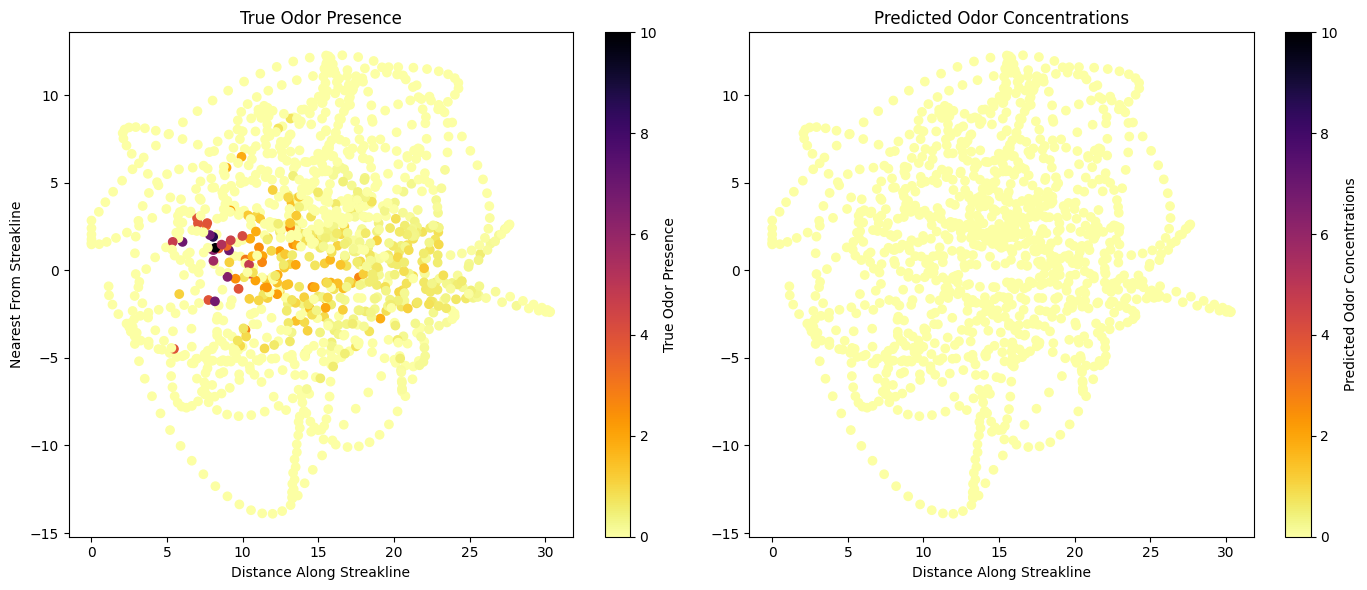

In [94]:

# Visualize the results
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# True Odor Presence (Binary)
sc1 = axes[0].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=new_test_df['odor'], cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Presence')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Concentrations (Continuous)
sc2 = axes[1].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=predictions_filled, cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Concentrations')
axes[1].set_title('Predicted Odor Concentrations')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
plt.show()


### ONLY USING SCIPY GPR

In [3]:
# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

# Combine all data for training a single GPR model
folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)
combined_df['odor_binary'] = combined_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Subsample the combined data for faster training
data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor_binary'].values  

# Initialize the MinMaxScaler
use_scaler = True  # Set this to False if you don't want to use the scaler

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

# Train the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
gp.fit(X_scaled, y)

# Save the trained model and scaler
trained_model = gp
trained_scaler = scaler

print("Spatial Model Training Done")

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Spatial Model Training Done


In [5]:
# import joblib

# model_filename = 'trained_model_may29_binary.joblib'
# scaler_filename = 'trained_scaler_may29_binary.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

Model saved to trained_model_may29_binary.joblib
Scaler saved to trained_scaler_may29_binary.joblib


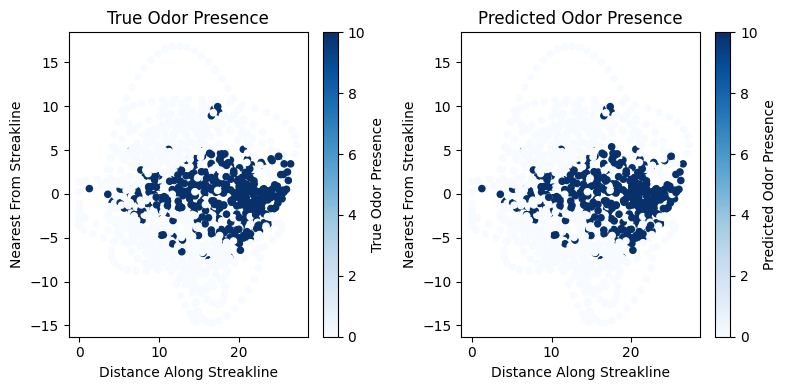

In [4]:
# Predicting spatial values using the combined GPR model
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag20.h5"
new_test_df = pd.read_hdf(test_file_path)
new_test_df = new_test_df.reset_index(drop=True)

new_test_df['odor_binary'] = new_test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Use the combined trained model and scaler
gp = trained_model
scaler = trained_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 5, 10, 0)  # Use a threshold of 3 to classify 0 or 10

# Visualize the results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor_binary'], cmap='Blues', s=20)
plt.colorbar(label='True Odor Presence')
plt.title('True Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_binary, cmap='Blues', s=20)
plt.colorbar(label='Predicted Odor Presence')
plt.title('Predicted Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


### Using Scipy GPR to train multiple datasets and predict continous values

In [14]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1) 

use_scaler = True  

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler

print("Spatial Model Training Done")

: 

In [7]:
# import joblib

# model_filename = 'trained_model_may29_cont.joblib'
# scaler_filename = 'trained_scaler_may29_cont.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

Model saved to trained_model_may29_cont.joblib
Scaler saved to trained_scaler_may29_cont.joblib


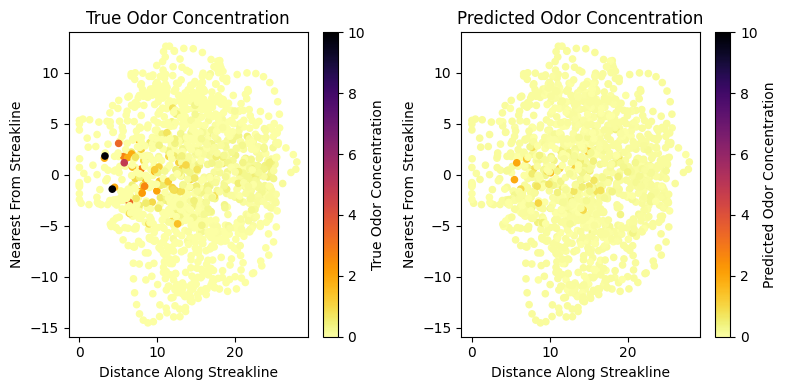

In [11]:
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/diag10.h5"
new_test_df = pd.read_hdf(test_file_path)
new_test_df = new_test_df.reset_index(drop=True)

gp = trained_model
scaler = trained_scaler
target_scaler = trained_target_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions to the original odor value scale
new_y_pred_mean = target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Clip the predictions to be within the range [0, 10]
new_y_pred_mean = np.clip(new_y_pred_mean, 0, 10)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_mean, cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


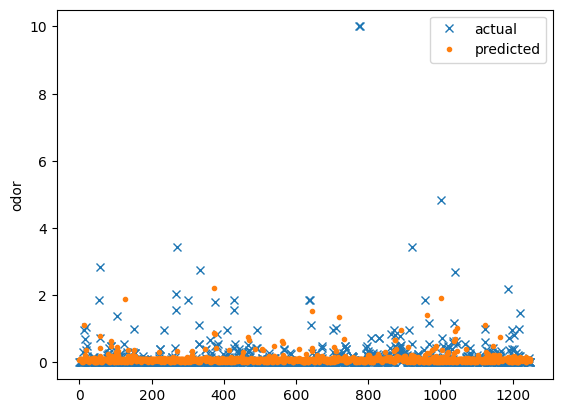

In [13]:
plt.plot(new_test_df.odor, 'x', label = 'actual')
plt.plot(new_y_pred_mean, 'o', markersize=3, label = 'predicted')
plt.ylabel('odor')
plt.legend()